
## CEM vs NES vs CMA–ES


### 0. Imports & Settings

In [1]:

import numpy as np, time, math, matplotlib.pyplot as plt, pandas as pd
from dataclasses import dataclass, field

np.random.seed(42)
DOMAIN_LOW, DOMAIN_HIGH = -5.0, 5.0
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.rcParams['axes.grid'] = True

BRANIN_MINIMA = [(-np.pi, 12.275), (np.pi, 2.275), (9.42478, 2.475)]
TARGET_MINIMA = {
    'ackley':     [(0.0, 0.0)],
    'rosenbrock': [(1.0, 1.0)],
    'branin':     BRANIN_MINIMA,
    'rastrigin':  [(0.0, 0.0)],
}

def nearest_min_error(mu: np.ndarray, fname: str) -> float:
    mins = np.array(TARGET_MINIMA[fname])
    d = np.linalg.norm(mins - mu.reshape(1, -1), axis=1)
    return float(np.min(d))

def clip_box(x):
    return np.minimum(np.maximum(x, DOMAIN_LOW), DOMAIN_HIGH)


### 1. Benchmarks

In [2]:

def f_ackley(z):
    x, y = z
    return -20.0*np.exp(-0.2*np.sqrt(0.5*(x*x+y*y))) - np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y))) + np.e + 20.0

def f_rosenbrock(z):
    x, y = z
    return (1.0 - x)**2 + 5.0 * (y - x**2)**2

def f_branin(z):
    x, y = z
    b = 5.1 / (4.0 * np.pi**2); c = 5.0 / np.pi; r = 6.0; s = 10.0; t = 1.0/(8.0*np.pi)
    return (y - b*x**2 + c*x - r)**2 + s*(1 - t)*np.cos(x) + s

def f_rastrigin(z):
    x, y = z
    return 20.0 + (x*x - 10.0*np.cos(2*np.pi*x)) + (y*y - 10.0*np.cos(2*np.pi*y))

F_MAP = {'ackley': f_ackley, 'rosenbrock': f_rosenbrock, 'branin': f_branin, 'rastrigin': f_rastrigin}


### 2. Algorithms (history tracking)

In [3]:

from dataclasses import dataclass, field

@dataclass
class CEMResult:
    x_best: np.ndarray; f_best: float; iters: int
    mu_hist: list; fmu_hist: list

def cross_entropy_method_hist(f, mu0, Sigma0, k_max, m=40, m_elite=10, seed=42):
    rng = np.random.default_rng(seed)
    mu = mu0.copy(); Sigma = Sigma0.copy(); n = len(mu)
    mu_hist, fmu_hist = [mu.copy()], [f(mu)]
    x_best, f_best = mu.copy(), fmu_hist[-1]
    for _ in range(k_max):
        xs = rng.multivariate_normal(mu, Sigma, size=m); xs = np.clip(xs, DOMAIN_LOW, DOMAIN_HIGH)
        vals = np.array([f(x) for x in xs]); order = np.argsort(vals); elites = xs[order[:m_elite]]
        mu = elites.mean(axis=0); Sigma = np.cov(elites.T, bias=False) + 1e-8*np.eye(n)
        mu_hist.append(mu.copy()); fmu_hist.append(f(mu))
        if vals[order[0]] < f_best: x_best, f_best = xs[order[0]].copy(), vals[order[0]]
    return CEMResult(x_best, f_best, k_max, mu_hist, fmu_hist)

@dataclass
class NESResult:
    x_best: np.ndarray; f_best: float; iters: int
    mu_hist: list; fmu_hist: list

def natural_evolution_strategies_hist(f, mu0, A0, k_max, m=60, alpha=0.005, seed=42):
    rng = np.random.default_rng(seed)
    mu = mu0.copy(); A  = A0.copy(); n  = len(mu)
    mu_hist, fmu_hist = [mu.copy()], [f(mu)]
    x_best, f_best = mu.copy(), fmu_hist[-1]
    for _ in range(k_max):
        Sigma = A.T @ A; Sigma = 0.5*(Sigma + Sigma.T) + 1e-8*np.eye(n)
        xs = rng.multivariate_normal(mu, Sigma, size=m); xs = np.clip(xs, DOMAIN_LOW, DOMAIN_HIGH)
        inv_Sigma = np.linalg.pinv(Sigma); g_mu = np.zeros(n)
        for x in xs:
            fx = f(x); g_mu += fx * (inv_Sigma @ (x - mu))
        g_mu /= m; mu = mu - alpha * g_mu
        Sigma = A.T @ A; Sigma = 0.5*(Sigma + Sigma.T) + 1e-8*np.eye(n); inv_Sigma = np.linalg.pinv(Sigma)
        g_A = np.zeros_like(A)
        for x in xs:
            dx = (x - mu).reshape(n,1); g_Sigma = 0.5 * (inv_Sigma @ (dx @ dx.T) @ inv_Sigma - inv_Sigma)
            g_A += f(x) * (A @ (g_Sigma + g_Sigma.T))
        A = A - alpha * (g_A / m)
        mu_hist.append(mu.copy()); fmu_hist.append(f(mu))
        vals = np.array([f(x) for x in xs]); idx = np.argmin(vals)
        if vals[idx] < f_best: x_best, f_best = xs[idx].copy(), vals[idx]
    return NESResult(x_best, f_best, k_max, mu_hist, fmu_hist)

@dataclass
class CMAESResult:
    x_best: np.ndarray; f_best: float; iters: int
    mu_hist: list; fmu_hist: list

def covariance_matrix_adaptation_hist(f, x0, k_max, sigma=1.5, seed=42):
    rng = np.random.default_rng(seed)
    mu = x0.copy(); n = len(mu)
    m = 4 + int(np.floor(3*np.log(n))); m_elite = m // 2
    ws = np.log((m + 1.0)/2.0) - np.log(np.arange(1, m+1))
    ws[:m_elite] = ws[:m_elite] / np.sum(ws[:m_elite]); mu_eff = 1.0 / np.sum(ws[:m_elite]**2)
    c_sigma = (mu_eff + 2.0)/(n + mu_eff + 5.0)
    d_sigma = 1.0 + 2.0*max(0.0, np.sqrt((mu_eff-1.0)/(n+1.0)) - 1.0) + c_sigma
    c_c = (4.0 + mu_eff/n)/(n + 4.0 + 2.0*mu_eff/n)
    c1 = 2.0/(((n+1.3)**2) + mu_eff)
    c_mu = min(1 - c1, 2.0*(mu_eff - 2.0 + 1.0/mu_eff)/(((n+2.0)**2) + mu_eff))
    ws[m_elite:] *= -(1.0 + c1/c_mu)/np.sum(ws[m_elite:])
    E = (n**0.5) * (1.0 - 1.0/(4.0*n) + 1.0/(21.0*n*n))
    p_sigma = np.zeros(n); p_c = np.zeros(n); C = np.eye(n)
    mu_hist, fmu_hist = [mu.copy()], [f(mu)]
    x_best, f_best = mu.copy(), fmu_hist[-1]
    for k in range(1, k_max+1):
        try:
            C = 0.5*(C + C.T) + 1e-12*np.eye(n)
            xs = rng.multivariate_normal(mu, (sigma**2) * C, size=m)
        except np.linalg.LinAlgError:
            C = np.eye(n); xs = rng.multivariate_normal(mu, (sigma**2) * C, size=m)
        xs = np.clip(xs, DOMAIN_LOW, DOMAIN_HIGH)
        ys = np.array([f(x) for x in xs]); isort = np.argsort(ys)
        deltas = [(xs[i] - mu)/sigma for i in range(m)]
        delta_w = np.zeros(n)
        for i in range(m_elite): delta_w += ws[i] * deltas[isort[i]]
        mu = mu + sigma * delta_w
        evals, evecs = np.linalg.eigh(C); evals = np.maximum(evals, 1e-14)
        C_inv_sqrt = (evecs @ np.diag(1.0/np.sqrt(evals)) @ evecs.T)
        p_sigma = (1.0 - c_sigma)*p_sigma + np.sqrt(c_sigma*(2.0 - c_sigma)*mu_eff) * (C_inv_sqrt @ delta_w)
        sigma = sigma * math.exp(c_sigma/d_sigma * (np.linalg.norm(p_sigma)/E - 1.0))
        left = np.linalg.norm(p_sigma) / np.sqrt(1.0 - (1.0 - c_sigma)**(2.0*k))
        h_sigma = 1 if left < (1.4 + 2.0/(n + 1.0)) * E else 0
        p_c = (1.0 - c_c)*p_c + h_sigma * np.sqrt(c_c*(2.0 - c_c)*mu_eff) * delta_w
        w0 = np.zeros(m)
        for i in range(m):
            v = C_inv_sqrt @ deltas[isort[i]]; denom = np.linalg.norm(v)
            w0[i] = ws[i] if ws[i] >= 0 else (n * ws[i] / (denom*denom if denom > 1e-14 else 1e-14))
        C = (1.0 - c1 - c_mu)*C + c1*(np.outer(p_c, p_c) + (1 - h_sigma)*c_c*(2 - c_c)*C)
        for i in range(m): C += c_mu * w0[i] * np.outer(deltas[isort[i]], deltas[isort[i]])
        C = 0.5*(C + C.T) + 1e-12*np.eye(n)
        mu_hist.append(mu.copy()); fmu_hist.append(f(mu))
        if ys[isort[0]] < f_best: x_best, f_best = xs[isort[0]].copy(), ys[isort[0]]
    return CMAESResult(x_best, f_best, k_max, mu_hist, fmu_hist)


### 3. Run & collect histories

In [4]:

MU0 = {'ackley':np.array([1.0,1.0]), 'rosenbrock':np.array([0.0,2.0]), 'branin':np.array([2.0,2.0]), 'rastrigin':np.array([-1.0,1.0])}
Sigma0 = np.array([[1.0,0.2],[0.2,2.0]])
A0 = np.eye(2)

histories = {}
for fname in ['ackley','rosenbrock','branin','rastrigin']:
    f = F_MAP[fname]
    cem = cross_entropy_method_hist(f, MU0[fname], Sigma0, k_max=10, m=40, m_elite=10, seed=42)
    nes = natural_evolution_strategies_hist(f, MU0[fname], A0.copy(), k_max=30, m=60, alpha=0.005, seed=42)
    cma = covariance_matrix_adaptation_hist(f, MU0[fname].copy(), k_max=200, sigma=1.5, seed=42)
    histories[fname] = {
        'CEM': {'mus': np.array(cem.mu_hist), 'fmus': np.array(cem.fmu_hist)},
        'NES': {'mus': np.array(nes.mu_hist), 'fmus': np.array(nes.fmu_hist)},
        'CMA-ES': {'mus': np.array(cma.mu_hist), 'fmus': np.array(cma.fmu_hist)},
    }
print('Histories ready:', list(histories.keys()))


Histories ready: ['ackley', 'rosenbrock', 'branin', 'rastrigin']


### 4. Convergence plots (per function: error & objective)

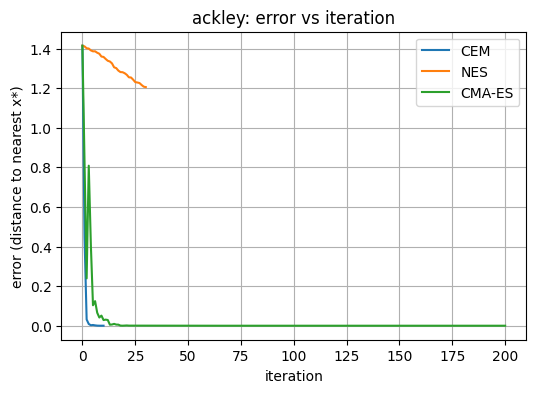

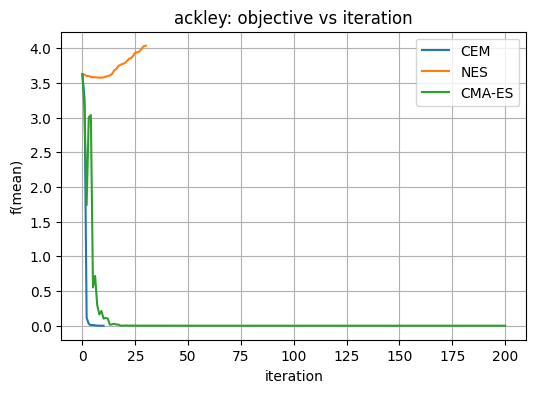

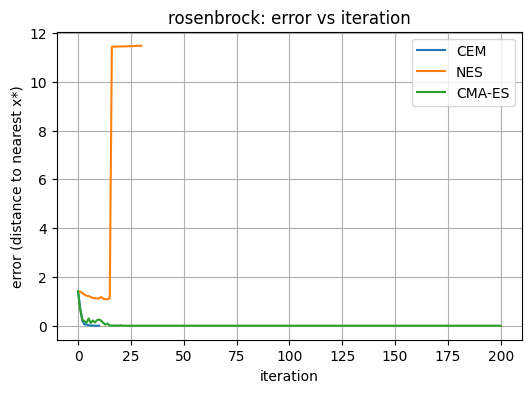

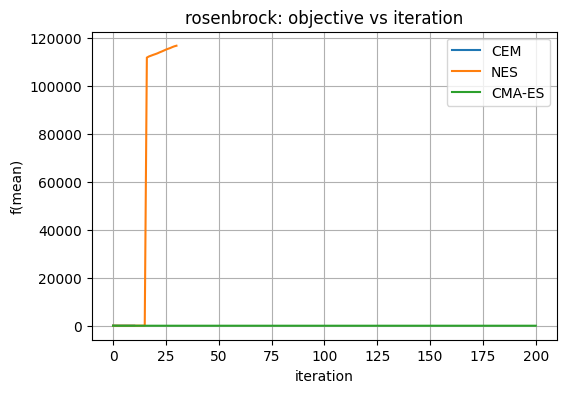

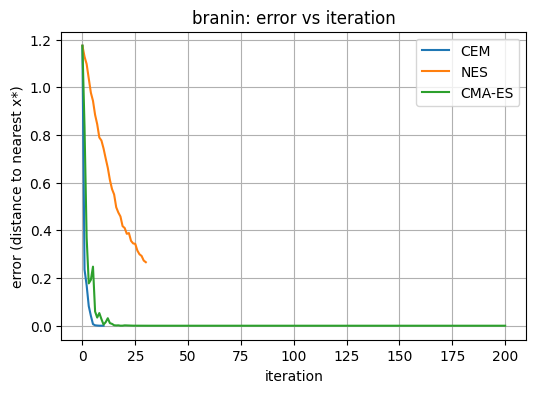

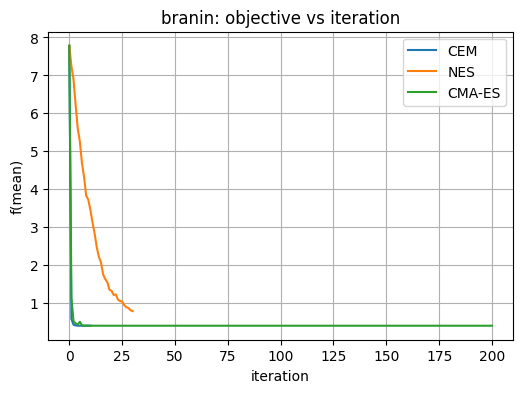

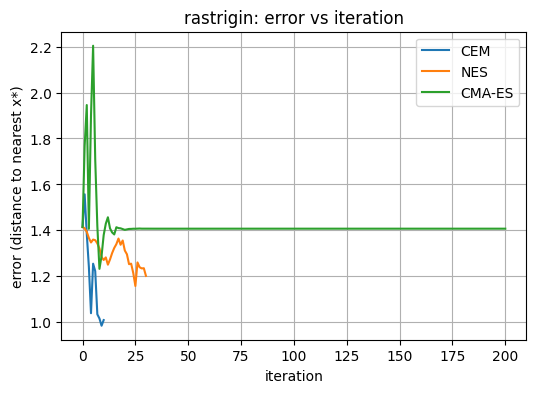

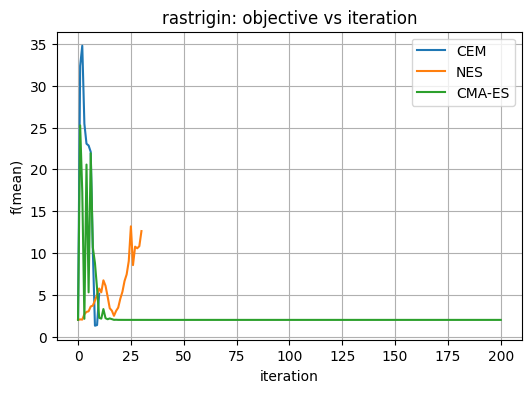

Done.


In [5]:

def plot_conv(fname, H):
    # error
    plt.figure()
    for method, data in H.items():
        errs = np.array([nearest_min_error(mu, fname) for mu in data['mus']])
        plt.plot(np.arange(len(errs)), errs, label=method)
    plt.xlabel('iteration'); plt.ylabel('error (distance to nearest x*)')
    plt.title(f'{fname}: error vs iteration'); plt.legend(); plt.show()
    # objective
    plt.figure()
    for method, data in H.items():
        plt.plot(np.arange(len(data['fmus'])), data['fmus'], label=method)
    plt.xlabel('iteration'); plt.ylabel('f(mean)')
    plt.title(f'{fname}: objective vs iteration'); plt.legend(); plt.show()

for fname in ['ackley','rosenbrock','branin','rastrigin']:
    plot_conv(fname, histories[fname])
print('Done.')
